[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)

# Tutorial 8 - Regression
## By Alexander Henkes (https://orcid.org/0000-0003-4615-9271) 
## and 
## Jason K. Eshraghian (www.jasoneshraghian.com)


using Google Colab:
<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_1_spikegen.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)


The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". arXiv preprint arXiv:2109.12894, September 2021.](https://arxiv.org/abs/2109.12894) </cite>

# ================================================================
# +++++++++++++++++++++++++++TODO+++++++++++++++++++++++++++++++
# ================================================================


## * Make the problem statement clear by overlaying the objective function and original membrane potential before training starts

## * (Optional) Perhaps do a LIF-only network, and then maybe motivate how an SLSTM performs better? 

## * Add a brief explanation behind the SLSTM / I can draw up a computational graph in Visio (we presented the SConvLSTM in this paper, so I might be able to just dumb down the explanation from here: https://www.techrxiv.org/articles/preprint/Neuromorphic_Deep_Spiking_Neural_Networks_for_Seizure_Detection/20444970) 

## * (Optional) We could use the same approach to performing a classification task. E.g., apply regression to the membrane potential s.t. it reaches >threshold for the correct class. I've done this quite a lot in the past to good results.

# ================================================================

In this tutorial, you will learn how to use snnTorch to:
* carry out regression using SNN using
* LIFs,
* Recurrent LIFs,
* SLSTMs,
* using different strategies


# Import, seed and training parameters

In [52]:
import matplotlib.pyplot as plt
import numpy
import random
import snntorch
import snntorch.surrogate
import statistics
import torch
import torch.utils.data
import tqdm

In [53]:
# Seed
torch.manual_seed(0)
random.seed(0)
numpy.random.seed(0)

We want to test out some functions, which can be chosen using the "MODE" flag. For now, we stick to "linear" and "sqrt".

In [54]:
# Training Parameters
TIMESTEPS = 10
NUM_SAMPLES = 1
BATCH_SIZE = NUM_SAMPLES
ITER = 1000
HIDDEN = 128
# 'linear' or 'sqrt'
MODE = "sqrt"
TEST = False
LEARNING_RATE = 1e-3
DEVICE = (
    torch.device("cuda")
    if torch.cuda.is_available()
    else torch.device("cpu")
)

# LIF

First, let us try a simple network using only LIF layers without recurrence. These architectures should work just fine, if there is no strong time dependency in the data, i.e., the next time step does not depend on the previous one.

In [57]:
class LIF(torch.nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, timesteps, hidden):
        super().__init__()
        self.timesteps = timesteps
        self.hidden = hidden

        # spike_grad = snntorch.surrogate.atan()
        spike_grad = snntorch.surrogate.fast_sigmoid()
        
        beta_in = torch.rand(self.hidden)
        thr_in = torch.rand(self.hidden)

        self.fc_in = torch.nn.Linear(in_features=1, out_features=self.hidden)
        self.lif_in = snntorch.Leaky(
            beta=beta_in,
            threshold=thr_in,
            learn_beta=True,
            learn_threshold=True,
            spike_grad=spike_grad,
            reset_mechanism="subtract",
        )
        
        beta_hidden = torch.rand(self.hidden)
        thr_hidden = torch.rand(self.hidden)

        self.fc_hidden = torch.nn.Linear(in_features=self.hidden, out_features=self.hidden)
        self.lif_hidden = snntorch.Leaky(
            beta=beta_hidden,
            threshold=thr_hidden,
            learn_beta=True,
            learn_threshold=True,
            spike_grad=spike_grad,
            reset_mechanism="subtract",
        )

        beta_out = torch.rand(1)

        self.fc_out = torch.nn.Linear(in_features=self.hidden, out_features=1)
        self.li_out = snntorch.Leaky(
            beta=beta_out,
            threshold=1.0,
            learn_beta=True,
            spike_grad=spike_grad,
            reset_mechanism="none",
        )

    def forward(self, x):
        """Forward pass for several time steps."""
        mem_in = self.lif_in.init_leaky()
        mem_hidden = self.lif_hidden.init_leaky()
        mem_out = self.li.init_leaky()

        cur_out_rec = []
        mem_out_rec = []
        spk_out_rec = []

        for step in range(self.timesteps):
            x_timestep = x[step, :, :]

            cur_in = self.fc_in(x_timestep)
            spk_in, mem_in = self.lif_in(cur_in, mem_in)
            
            cur_hidden = self.fc_hidden(spk_in)
            spk_hidden, mem_hidden = self.li(cur_hidden, mem_hidden)
 
            cur_out = self.fc_out(spk_hidden) # mem_hidden works better!
            cur_out, mem_out = self.li_out(cur_out, mem_out)

            cur_out_rec.append(cur_out)
            mem_out_rec.append(mem_out)
            spk_out_rec.append(spk_in)

        return (
            torch.stack(cur_out_rec, dim=0),
            torch.stack(mem_out_rec, dim=0),
            torch.stack(spk_out_rec, dim=0),
        )

# RLIF

For short-time dependencies, reccurence can be introduced in the LIF, resulting in an RLIF. Typically, time series with dependencies up to around ten timesteps can be well captured by standard recurrent neurons.

In [ ]:
#TODO

# SLSTM

For long-time dependencies, some sort of "memory" has to be introduced in our architecture. One of the most common and succesfull approaches towards time series with long dependencies was introduced in the 1990th and is called "Long-short-term memory" [...]. By introducing a memory ..... (architecture, pictures etc.)

In [57]:
class SLSTM(torch.nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, timesteps, hidden):
        super().__init__()
        self.timesteps = timesteps
        self.hidden = hidden

        # spike_grad = snntorch.surrogate.atan() --> Not in the current version
        spike_grad = snntorch.surrogate.fast_sigmoid()
        
        thr_lstm_1 = torch.rand(self.hidden)

        self.slstm_1 = snntorch.SLSTM(
            input_size=1,
            hidden_size=self.hidden,
            spike_grad=spike_grad,
            learn_threshold=True,
            threshold=thr_lstm_1,
            reset_mechanism="none",
        )

        beta_out = torch.rand(1)
        thr_out = torch.rand(1)

        self.fc_out = torch.nn.Linear(in_features=self.hidden, out_features=1)
        self.li_out = snntorch.Leaky(
            beta=beta_out,
            threshold=thr_out,
            learn_beta=True,
            learn_threshold=True,
            spike_grad=spike_grad,
            reset_mechanism="none",
        )

    def forward(self, x):
        """Forward pass for several time steps."""
        mem_in = self.lif.init_leaky()
        syn_lstm_1, mem_lstm_1 = self.slstm_1.init_slstm()
        mem_out = self.li.init_leaky()

        cur_out_rec = []
        mem_out_rec = []
        spk_out_rec = []

        for step in range(self.timesteps):
            x_timestep = x[step, :, :]

            spk_in = x_timestep
            spk_lstm_1, syn_lstm_1, mem_lstm_1 = self.slstm_1(
                spk_in, syn_lstm_1, mem_lstm_1
            )
            cur_out = self.fc_out(mem_lstm_1)
            cur_out, mem_out = self.li_out(cur_out, mem_out)

            cur_out_rec.append(cur_out)
            mem_out_rec.append(mem_out)
            spk_out_rec.append(spk_in)

        return (
            torch.stack(cur_out_rec, dim=0),
            torch.stack(mem_out_rec, dim=0),
            torch.stack(spk_out_rec, dim=0),
        )

# Introduction

Different strategies for regression


1.   **Membrane potential**: ...

2.   **The other thing**: ...

In this tutorial, we will assume we have some non-spiking input data (i.e., the MNIST dataset) and that we want to encode it into spikes using a few different techniques. So let's get started! 

Install the latest PyPi distribution of snnTorch:

In [51]:
!pip install snntorch

## 1. Setting up a regression dataset

### 1.1. Import packages and setup environment

### Create dataset

In [55]:
class Regression_dataset(torch.utils.data.Dataset):
    """Simple regression dataset."""

    def __init__(self, timesteps, num_samples, mode):
        """Linear relation between input and output"""
        self.num_samples = num_samples
        feature_lst = []

        for idx in range(num_samples):
            end = float(torch.rand(1))
            lin_vec = torch.linspace(start=0.0, end=end, steps=timesteps)
            feature = lin_vec.view(timesteps, 1)
            feature_lst.append(feature)

        self.features = torch.stack(feature_lst, dim=1)

        if mode == "linear":
            self.labels = self.features * 1

        elif mode == "sqrt":
            slope = float(torch.rand(1))
            self.labels = torch.sqrt(self.features * slope)

        else:
            raise NotImplementedError("'linear', 'sqrt'")

    def __len__(self):
        """Number of samples."""
        return self.num_samples

    def __getitem__(self, idx):
        """General implementation, but we only have one sample."""
        return self.features[:, idx, :], self.labels[:, idx, :]


### 1.3 Create DataLoaders
The Dataset objects created above load data into memory, and the DataLoader will serve it up in batches. DataLoaders in PyTorch are a handy interface for passing data into a network. They return an iterator divided up into mini-batches of size ``batch_size``.

In [56]:
dataloader = torch.utils.data.DataLoader(
    dataset=Regression_dataset(
        timesteps=TIMESTEPS,
        num_samples=NUM_SAMPLES,
        mode=MODE,
    ),
    batch_size=BATCH_SIZE,
    drop_last=True,
    shuffle=True,
)

## 2. Model



In [58]:
model = SNN(timesteps=TIMESTEPS, hidden=HIDDEN).to(DEVICE)

## 3. Training

In [59]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
loss_function = torch.nn.MSELoss()

loss_hist = []
with tqdm.trange(ITER) as pbar:
    for _ in pbar:
        train_batch = iter(dataloader)
        minibatch_counter = 0
        loss_epoch = []

        for feature, label in train_batch:
            feature = torch.swapaxes(input=feature, axis0=0, axis1=1)
            label = torch.swapaxes(input=label, axis0=0, axis1=1)
            feature = feature.to(DEVICE)
            label = label.to(DEVICE)
            cur, mem, spk = model(feature)
            # spk_lst.append(spk.detach().cpu())

            loss_val = loss_function(mem, label)
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            loss_hist.append(loss_val.item())
            loss_epoch.append(loss_val.item())

            minibatch_counter += 1

            avg_batch_loss = sum(loss_epoch) / minibatch_counter
            pbar.set_postfix(loss="%.3e" % avg_batch_loss)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 77.00it/s, loss=8.466e-08]


## 4. Evaluation

In [60]:
loss_function = torch.nn.L1Loss()
with torch.no_grad():
    model.eval()

    test_batch = iter(dataloader)

    minibatch_counter = 0
    rel_err_lst = []

    for feature, label in test_batch:
        feature = torch.swapaxes(input=feature, axis0=0, axis1=1)
        label = torch.swapaxes(input=label, axis0=0, axis1=1)

        feature = feature.to(DEVICE)
        label = label.to(DEVICE)

        cur, mem, spk = model(feature)

        rel_err = torch.linalg.norm(
            (mem - label), dim=-1
        ) / torch.linalg.norm(label, dim=-1)
        rel_err = torch.mean(rel_err[1:, :])

        loss_val = loss_function(mem, label)

        loss_hist.append(loss_val.item())
        rel_err_lst.append(rel_err.item())

        minibatch_counter += 1

    mean_L1 = statistics.mean(loss_hist)
    mean_rel = statistics.mean(rel_err_lst)

print(f"{'Mean L1-loss:':<{20}}{mean_L1:1.2e}")
print(f"{'Mean rel. err.:':<{20}}{mean_rel:1.2e}")


Mean L1-loss:       1.70e-03
Mean rel. err.:     4.62e-04


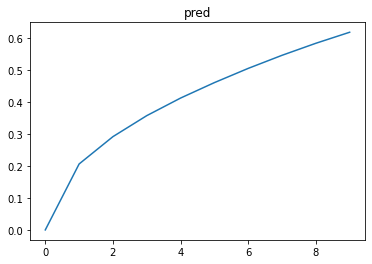

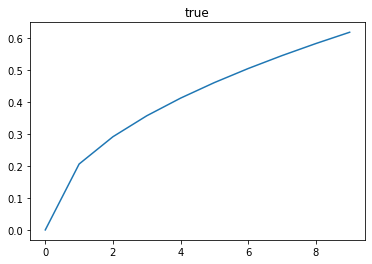

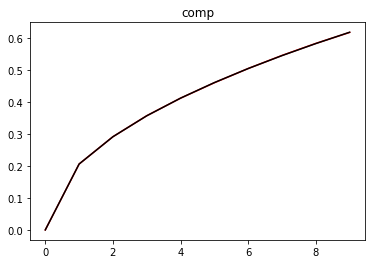

In [61]:
mem = mem.cpu()
label = label.cpu()
plt.figure(1)
plt.title("pred")
for i in range(BATCH_SIZE):
    plt.plot(mem[:, i, :])

plt.figure(2)
plt.title("true")
for i in range(BATCH_SIZE):
    plt.plot(label[:, i, :])

plt.figure(3)
plt.title("comp")
for i in range(BATCH_SIZE):
    plt.plot(mem[:, i, :], color="red")
    plt.plot(label[:, i, :], color="black")
plt.show()